# Experiment 5: Sequential Train / Pure Test Split

In this experiment, we still respect the **dropped timesteps** , but we change the training regime:

1.  **Split**: We divide the *valid* timesteps into an 80% Training Set and a 20% Test Set.
2.  **Train Phase**: We train sequentially on the first 80% of valid timesteps. We update the model weights at each step.
3.  **Test Phase**: We *only evaluate* on the last 20% of valid timesteps. We **do not** update the model weights (weights are frozen). This tests the model's ability to generalize to future unseen data without immediate adaptation.

In [23]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
import time
import matplotlib.pyplot as plt

# Load Data
print("Loading data...")
classes_df = pd.read_csv("raw_data/elliptic_bitcoin_dataset/elliptic_txs_classes.csv")
edgelist_df = pd.read_csv("raw_data/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv")
features_df = pd.read_csv("raw_data/elliptic_bitcoin_dataset/elliptic_txs_features.csv", header=None)

# Rename feature columns (0=txId, 1=time_step)
features_df.columns = ['txId', 'time_step'] + [f'feat_{i}' for i in range(165)]

Loading data...


In [24]:
# Data Preprocessing
print("Preprocessing data...")

# 1. Map classes: 'unknown'=0, '1'=1 (illicit), '2'=2 (licit)
classes_df['class'] = classes_df['class'].map({'unknown': 0, '1': 1, '2': 2})

# 2. Merge class labels into features
df = features_df.merge(classes_df, on='txId', how='left')

# 3. Create node ID mapping
node_ids = df['txId'].values
node_id_to_idx = {node_id: idx for idx, node_id in enumerate(node_ids)}

# 4. Prepare Edge Index
edge_list = []
for _, row in edgelist_df.iterrows():
    if row['txId1'] in node_id_to_idx and row['txId2'] in node_id_to_idx:
        edge_list.append([node_id_to_idx[row['txId1']], node_id_to_idx[row['txId2']]])

edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()

# 5. Prepare Features and Labels tensors
x = torch.tensor(df.iloc[:, 2:-1].values, dtype=torch.float)
y = torch.tensor(df['class'].values, dtype=torch.long)
time_steps = torch.tensor(df['time_step'].values, dtype=torch.long)

print(f"Nodes: {x.shape[0]}, Edges: {edge_index.shape[1]}, Features: {x.shape[1]}")

Preprocessing data...
Nodes: 203769, Edges: 234355, Features: 165


In [26]:
# GCN Model Definition
class GCNFraudDetector(torch.nn.Module):
    def __init__(self, in_features, hidden=64, out_classes=3, dropout=0.5):
        super().__init__()
        self.gcn1 = GCNConv(in_features, hidden)
        self.gcn2 = GCNConv(hidden, hidden // 2)
        self.fc = torch.nn.Linear(hidden // 2, out_classes)
        self.dropout = dropout
    
    def forward(self, x, edge_index):
        x = self.gcn1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.gcn2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.fc(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [ ]:
# Helper Functions
def compute_class_weights(labels, device):
    n_illicit = (labels == 1).sum().float()
    n_licit = (labels == 2).sum().float()
    total = len(labels)
    
    # Handle edge case if a class is missing (though filtering should prevent this for illicit)
    if n_illicit == 0: weight_illicit = 1.0
    else: weight_illicit = total / (2.0 * n_illicit)
        
    if n_licit == 0: weight_licit = 1.0
    else: weight_licit = total / (2.0 * n_licit)
        
    return torch.tensor([1.0, weight_illicit, weight_licit], dtype=torch.float).to(device)

@torch.no_grad()
def evaluate(model, x, edge_index, mask, y):
    model.eval()
    out = model(x, edge_index)
    probs = F.softmax(out, dim=1)
    pred = out.argmax(dim=1)
    
    # Metrics on masked nodes
    y_true = y[mask].cpu().numpy()
    y_pred = pred[mask].cpu().numpy()
    y_probs = probs[mask][:, 1].cpu().numpy() # Prob of illicit
    
    # Binary conversion (1=illicit, 0=licit/unknown)
    # Note: We only evaluate on labeled nodes (1 or 2), so 2 becomes 0 in binary
    y_true_bin = (y_true == 1).astype(int)
    y_pred_bin = (y_pred == 1).astype(int)
    
    return {
        'accuracy': accuracy_score(y_true_bin, y_pred_bin),
        'precision': precision_score(y_true_bin, y_pred_bin, zero_division=0),
        'recall': recall_score(y_true_bin, y_pred_bin, zero_division=0),
        'f1': f1_score(y_true_bin, y_pred_bin, zero_division=0),
        'auc_roc': roc_auc_score(y_true_bin, y_probs) if len(np.unique(y_true_bin)) > 1 else 0.5,
        'auc_pr': average_precision_score(y_true_bin, y_probs) if len(np.unique(y_true_bin)) > 1 else 0.0
    }

Total Valid Timesteps: 35
Training Steps (28): [4, 7, 8, 9, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 34, 35, 36, 37]
Testing Steps (7): [38, 39, 40, 41, 42, 48, 49]

Starting Experiment 5...
Timestep   Phase      Accuracy     Precision    F1         Recall     Illicit Count
--------------------------------------------------------------------------------
4          TRAIN      0.9847       0.5769       0.7317     1.0000     30
7          TRAIN      0.9601       0.6901       0.8033     0.9608     102
8          TRAIN      0.9828       0.7701       0.8701     1.0000     67
9          TRAIN      0.9460       0.8931       0.9176     0.9435     248
11         TRAIN      0.9784       0.9085       0.9451     0.9847     131
13         TRAIN      0.9802       0.9630       0.9728     0.9828     291
14         TRAIN      0.9952       0.9556       0.9773     1.0000     43
15         TRAIN      0.9773       0.9290       0.9536     0.9796     147
16         TRAIN

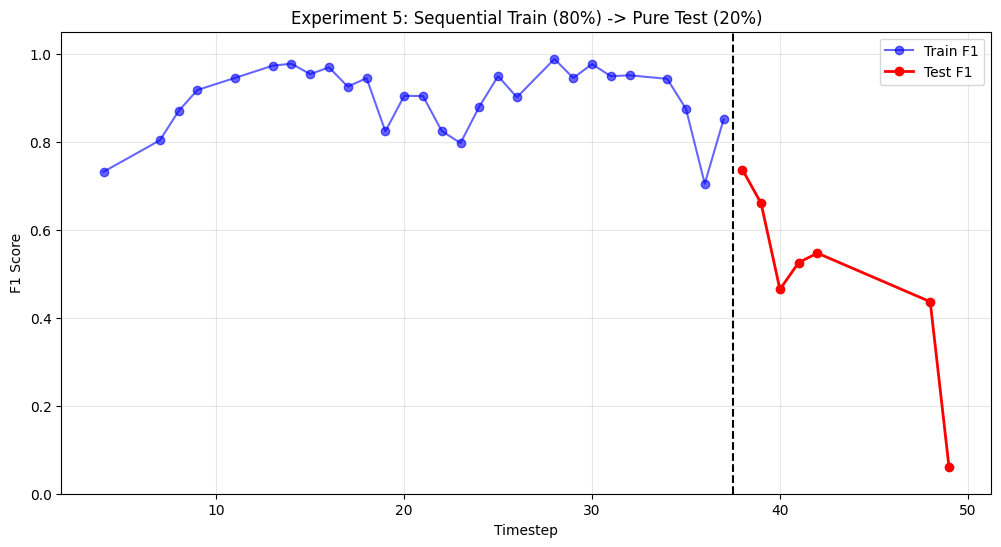


Experiment 5 Test Set Summary:
       accuracy  precision  recall      f1  auc_roc
count    7.0000     7.0000  7.0000  7.0000   7.0000
mean     0.9074     0.5103  0.5096  0.4900   0.8576
std      0.0273     0.1629  0.2650  0.2169   0.0612
min      0.8697     0.2000  0.0357  0.0606   0.7771
25%      0.8881     0.4808  0.3854  0.4504   0.8158
50%      0.9067     0.4949  0.5776  0.5255   0.8618
75%      0.9274     0.5990  0.6964  0.6033   0.8949
max      0.9442     0.7179  0.7901  0.7368   0.9427


In [ ]:

# 1. Define Split
num_valid = len(valid_timesteps)
split_idx = int(num_valid * 0.8)
train_timesteps = valid_timesteps[:split_idx]
test_timesteps = valid_timesteps[split_idx:]

print(f"Total Valid Timesteps: {num_valid}")
print(f"Training Steps ({len(train_timesteps)}): {train_timesteps}")
print(f"Testing Steps ({len(test_timesteps)}): {test_timesteps}")

# 2. Initialize New Model
model_exp5 = GCNFraudDetector(in_features=x.shape[1]).to(device)
optimizer_exp5 = torch.optim.Adam(model_exp5.parameters(), lr=0.01)

results_exp5 = []

print("\nStarting Experiment 5...")
print(f"{'Timestep':<10} {'Phase':<10} {'Accuracy':<12} {'Precision':<12} {'F1':<10} {'Recall':<10} {'Illicit Count'}")
print("-" * 80)

# 3. Train Phase Loop
for t in train_timesteps:
    # Create mask
    current_mask = ((time_steps == t) & (y > 0))
    n_illicit = ((time_steps == t) & (y == 1)).sum().item()
    
    # Train
    class_weights = compute_class_weights(y[current_mask], device)
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
    
    model_exp5.train()
    for epoch in range(NUM_EPOCHS):
        optimizer_exp5.zero_grad()
        out = model_exp5(x, edge_index)
        loss = criterion(out[current_mask], y[current_mask])
        loss.backward()
        optimizer_exp5.step()
        
    metrics = evaluate(model_exp5, x, edge_index, current_mask, y)
    metrics['timestep'] = t
    metrics['phase'] = 'Train'
    results_exp5.append(metrics)
    print(f"{t:<10} {'TRAIN':<10} {metrics['accuracy']:.4f}       {metrics['precision']:.4f}       {metrics['f1']:.4f}     {metrics['recall']:.4f}     {n_illicit}")

print("-" * 80)
print("Switching to PURE TEST Phase (Weights Frozen)...")
print("-" * 80)

# 4. Test Phase Loop
for t in test_timesteps:
    # Create mask
    current_mask = ((time_steps == t) & (y > 0))
    n_illicit = ((time_steps == t) & (y == 1)).sum().item()
    
    # Evaluate ONLY (No training)
    metrics = evaluate(model_exp5, x, edge_index, current_mask, y)
    metrics['timestep'] = t
    metrics['phase'] = 'Test'
    results_exp5.append(metrics)
    print(f"{t:<10} {'TEST':<10} {metrics['accuracy']:.4f}       {metrics['precision']:.4f}       {metrics['f1']:.4f}     {metrics['recall']:.4f}     {n_illicit}")

# Visualization
res5_df = pd.DataFrame(results_exp5)
train_df = res5_df[res5_df['phase'] == 'Train']
test_df = res5_df[res5_df['phase'] == 'Test']

plt.figure(figsize=(12, 6))
plt.plot(train_df['timestep'], train_df['f1'], marker='o', label='Train F1', color='blue', alpha=0.6)
plt.plot(test_df['timestep'], test_df['f1'], marker='o', label='Test F1', color='red', linewidth=2)

plt.title('Experiment 5: Sequential Train (80%) -> Pure Test (20%)')
plt.xlabel('Timestep')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1.05)

# Mark split point
if len(test_timesteps) > 0:
    plt.axvline(x=test_timesteps[0]-0.5, color='black', linestyle='--', label='Train/Test Split')

plt.show()

print("\nExperiment 5 Test Set Summary:")
print(test_df[['accuracy', 'precision', 'recall', 'f1', 'auc_roc']].describe().round(4))

The above metrics are **macro-averaged** (mean across timesteps). For fair comparison to baseline models which use **pooled evaluation**, we also compute metrics on the combined test set.

In [47]:
# Experiment 5: Pooled Test Set Evaluation (Micro-averaged)
# Combine all test timesteps into a single mask and evaluate once

print("=" * 80)
print("EXPERIMENT 5: POOLED TEST SET EVALUATION (MICRO-AVERAGED)")
print("=" * 80)

# Create combined test mask for all test timesteps
test_mask_pooled = torch.zeros(len(y), dtype=torch.bool).to(device)
for t in test_timesteps:
    test_mask_pooled |= ((time_steps == t) & (y > 0))

# Count total nodes
n_test_nodes = test_mask_pooled.sum().item()
n_test_illicit = ((y[test_mask_pooled] == 1).sum().item())
n_test_licit = ((y[test_mask_pooled] == 2).sum().item())

print(f"\nPooled Test Set Composition:")
print(f"  Timesteps: {test_timesteps}")
print(f"  Total nodes: {n_test_nodes}")
print(f"  Illicit: {n_test_illicit} ({n_test_illicit/n_test_nodes*100:.2f}%)")
print(f"  Licit: {n_test_licit} ({n_test_licit/n_test_nodes*100:.2f}%)")

# Evaluate on pooled test set
pooled_metrics = evaluate(model_exp5, x, edge_index, test_mask_pooled, y)

print(f"\n" + "=" * 80)
print("POOLED TEST SET METRICS (for comparison to baseline models)")
print("=" * 80)
print(f"Accuracy:  {pooled_metrics['accuracy']*100:.2f}%")
print(f"Precision: {pooled_metrics['precision']*100:.2f}%")
print(f"Recall:    {pooled_metrics['recall']*100:.2f}%")
print(f"F1 Score:  {pooled_metrics['f1']*100:.2f}%")
print(f"AUC-ROC:   {pooled_metrics['auc_roc']:.4f}")
print(f"AUC-PR:    {pooled_metrics['auc_pr']:.4f}")
print("=" * 80)

print(f"\nComparison:")
print(f"  Macro-averaged (mean of {len(test_timesteps)} timesteps):")
print(f"    F1: {test_df['f1'].mean()*100:.2f}%, Precision: {test_df['precision'].mean()*100:.2f}%, Recall: {test_df['recall'].mean()*100:.2f}%")
print(f"  Micro-averaged (pooled {n_test_nodes} nodes):")
print(f"    F1: {pooled_metrics['f1']*100:.2f}%, Precision: {pooled_metrics['precision']*100:.2f}%, Recall: {pooled_metrics['recall']*100:.2f}%")

EXPERIMENT 5: POOLED TEST SET EVALUATION (MICRO-AVERAGED)

Pooled Test Set Composition:
  Timesteps: [38, 39, 40, 41, 42, 48, 49]
  Total nodes: 7383
  Illicit: 751 (10.17%)
  Licit: 6632 (89.83%)

POOLED TEST SET METRICS (for comparison to baseline models)
Accuracy:  90.45%
Precision: 52.83%
Recall:    57.26%
F1 Score:  54.95%
AUC-ROC:   0.8619


KeyError: 'auc_pr'